<a href="https://colab.research.google.com/github/ullattil/Self-Study-Notebooks/blob/master/Intro-to-ML/iml_pytorch_tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IML PyTorch Tutorial - Part 2: Autodiff and Basic Neural Network Models

In [ ]:
import torch
import numpy as np
from matplotlib import pyplot as plt

## Autodiff Basics

**Automatic Differentiation: The value of the derivative / gradient of a function is automatically computed for us.**

We don't have to derive the gradient of a function / chain of arithmetic operations by hand and implement it - pytorch does that for us.

In the following, we give an example on how to obtain the gradient of the function
$ f(x, y) = x (x+y)^2 $.






First we begin implementing the forward pass for $f$, that is, we specify the arithmetic steps for computing the function $f$:

In [ ]:
def f(x, y):
  c = x + y
  d = c**2
  return x * d

Then, we let pytorch know for which variables / tensors it has to keep track of the derivatives/gradients. For the respective tensors, we set `requires_grad=True`. Finally, we pass the input tensors into our function $f$ and get back the result of the computation.

In [ ]:
x = torch.tensor([3.0], requires_grad=True)
y = torch.tensor([-1.0], requires_grad=True)
f_val = f(x, y)
print(f_val)
print('df/dx:', x.grad)
print('df/dy:', y.grad)

tensor([12.], grad_fn=<MulBackward0>)
df/dx: None
df/dy: None


We have just created a computation graph on the fly in which `x` and `y` are the leaves and `f_val` is the root. Since we have not yet called the `backward()` function,
the gradient attributes of `x` and `y` are still empty. 

Let's change that! By calling the `backward()` function of our root tensor `f_val`, we initiate a backward pass starting from `f_val` which computes the gradients for all tensors in the graph who have `requires_grad=True`.

In [ ]:
f_val.backward()
print('df/dx:', x.grad)
print('df/dy:', y.grad)

df/dx: tensor([16.])
df/dy: tensor([12.])


## Creating and Training a Neural Network

#### Defining a Neural Network Model

Even though creating a neural network from scratch would not be that hard, the [torch.nn](https://pytorch.org/docs/stable/nn.html) module provides convenient functions that make working with neural networks much easier.

In particular, we use the `torch.nn.Module` base class to define a custom Multi-Layer Perceptron (MLP). This is done by _inheriting_ from the `torch.nn.Module` class.

We usually override two methods: `__init__` and `forward`. The `__init__` method is responsible for creating the tensors that we need to store the weights of our NN, as well as required activation functions. The `forward` method describes how the NN computes the output given the input. 

In [ ]:
class MultiLayerPerceptron(torch.nn.Module):

  def __init__(self, input_dim: int, ouput_dim: int):
    super().__init__()    # initialize the torch.nn.Module first

    # then we attach different layers/activations to self
    self.fc1 = torch.nn.Linear(input_dim, 64) # Wx+b
    self.fc2 = torch.nn.Linear(64, 64)
    self.fc_out = torch.nn.Linear(64, ouput_dim)
    self.activation_fn = torch.nn.Tanh()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    result = self.fc1(x)
    result = self.activation_fn(result)
    result = self.fc2(result)
    result = self.activation_fn(result)
    result = self.fc_out(result)
    return result

model = MultiLayerPerceptron(1, 1)

In [ ]:
for name, param in model.fc1.named_parameters():
    print(name, param.shape, param.requires_grad)

weight torch.Size([64, 1]) True
bias torch.Size([64]) True


### Generating some data and setting up some plot functionality



Now let's test our MLP and see how well it can learn from data

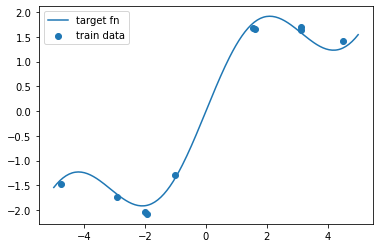

In [ ]:
# define a target function
def target_fn(x: np.ndarray) -> np.ndarray:
    return np.sin(x) + x / 2

# generate data from it
num_train_points = 10
x_rand = np.random.uniform(-5, 5, size=(num_train_points + 100, 1))
y_noisy = target_fn(x_rand) + np.random.normal(scale=0.1, size=x_rand.shape)

# split into train and test set
x_train, y_train = x_rand[:num_train_points], y_noisy[:num_train_points]
x_test, y_test = x_rand[num_train_points:], y_noisy[num_train_points:]

# plot the data
x_plot = np.linspace(-5, 5, 200).reshape((-1, 1))
plt.plot(x_plot, target_fn(x_plot), label='target fn')
plt.scatter(x_train, y_train, label='train data')
plt.legend()
plt.show()

In [ ]:
# convert the data to tensors
x_train_t = torch.from_numpy(x_train).float()
y_train_t = torch.from_numpy(y_train).float()
x_test_t = torch.from_numpy(x_test).float()
y_test_t = torch.from_numpy(y_test).float()
x_plot_t = torch.from_numpy(x_plot).float()

We now make a helper function to plot predictions of the NN on a grid of points (to make sense of what function the NN is computing). Remember that we need no gradient computation when doing prediction. Instead of disabling `require_grad` for each and every tensor, we can enclose all computations in a `with torch.nn.no_grad()` context, and pytorch will not compute the gradients. :

In [ ]:
# set up plotting function
def plot_predictions(model: torch.nn.Module, title=''):
    with torch.no_grad():
        y_pred_plot = model(x_plot_t).numpy()
    plt.plot(x_plot, target_fn(x_plot), label='target fun')
    plt.scatter(x_train, y_train, label='train data')
    plt.plot(x_plot, y_pred_plot, label='nn prediction')
    plt.title(title)
    plt.legend()
    plt.show()

### Setup NN Training

Next, we will instantiate a MLP object and specify the optimization method to use for training. There are several options in `torch.optim` module. Usually, the optimizer only needs to know about the parameters; the parameters themselves include the necessary information all optimizers need (that is, their value and their gradients). `model.parameters()` is a convenient method that gives back all tensors inside a `torch.nn.Module` object. Also, notice that all tensors defined in a model have `require_grad=True` by default.

In [ ]:
# set up optimizer
optim = torch.optim.SGD(model.parameters(), lr=2e-3)
# Alternative: adaptive learning rate optimizer Adam
# optim = torch.optim.Adam(model.parameters())

# print NN parameter sizes
for name, param in model.named_parameters():
  print(name, tuple(param.shape), param.requires_grad)

fc1.weight (64, 1) True
fc1.bias (64,) True
fc2.weight (64, 64) True
fc2.bias (64,) True
fc_out.weight (1, 64) True
fc_out.bias (1,) True


Any optimization task needs an objective. For us machine learners, this would be the loss. Note that the loss function shoule be able to get two Tensors (the prediction and the true values) as input and give a number as the loss of that batch. 

In [ ]:
# define loss function
def mse(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
  l2 = (y_pred - y_true)**2
  return torch.mean(l2)

### Forward & Backward Pass with NN

Each instance of `torch.nn.Module` is a callable, that is, it can act as a function that takes a tensor as an input, and gives the output of the NN as the output.

By just _applying_ the model to the data, no gradient calculation is performed, and if we need gradients, we have to call the `backward()` method on the output tensor of the model.

In [ ]:
print('Initially:', model.fc_out.bias.grad)

# forward pass
y_pred = model(x_train_t)
train_loss = mse(y_pred, y_train_t)
print('After fwd:', model.fc_out.bias.grad)

# backward pass
train_loss.backward()
print('After bwd:', model.fc_out.bias.grad)

Initially: None
After fwd: None
After bwd: tensor([0.4449])


Notice that if we run the same code again, the gradient is different! This is because we did not tell PyTorch that a new round of computation (aka. pass) has been started:

In [ ]:
# another fwd / bwd pass
y_pred = model(x_train_t)
train_loss = mse(y_pred, y_train_t)
train_loss.backward()
print('After 2nd bwd:', model.fc_out.bias.grad)

After 2nd bwd: tensor([0.8898])


To start the gradient computation from scratch, we have to explicitly "zero out" the gradients that are already computed for the tensors. This is vital, since if we do not do this, we will accumulate the gradients computed for previous passes into the current pass.

In [ ]:
# zero grad
optim.zero_grad()
print('After zero grads:', model.fc_out.bias.grad)

# another fwd / bwd pass
y_pred = model(x_train_t)
train_loss = mse(y_pred, y_train_t)
train_loss.backward()
print('After fwd / bwd pass with zero grads:', model.fc_out.bias.grad)

After zero grads: tensor([0.])
After fwd / bwd pass with zero grads: tensor([0.4449])


### Run the NN Training Loop

Now we are in the position to combine all the ingredients and do the training. In the following loop, at each iteration, we train on the whole training set. 

Iter 0 | train: 2.650482177734375 | test: 1.6797537803649902


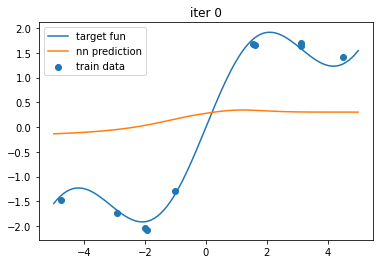

Iter 100 | train: 0.11727174371480942 | test: 0.15693292021751404
Iter 200 | train: 0.10038770735263824 | test: 0.14641672372817993
Iter 300 | train: 0.0865810215473175 | test: 0.13264186680316925
Iter 400 | train: 0.07478591054677963 | test: 0.11995046585798264
Iter 500 | train: 0.06464552134275436 | test: 0.10869956761598587
Iter 600 | train: 0.055925559252500534 | test: 0.09877777099609375
Iter 700 | train: 0.04845770075917244 | test: 0.0900549441576004
Iter 800 | train: 0.04210888594388962 | test: 0.08242321759462357
Iter 900 | train: 0.0367622897028923 | test: 0.07578852772712708
Iter 1000 | train: 0.032306838780641556 | test: 0.07006105780601501


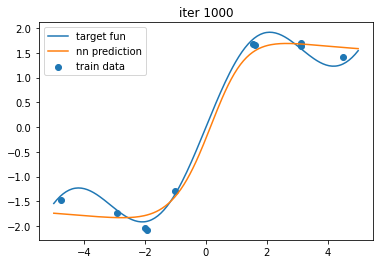

Iter 1100 | train: 0.02863311767578125 | test: 0.06515055894851685
Iter 1200 | train: 0.025633523240685463 | test: 0.06096554175019264
Iter 1300 | train: 0.023204240947961807 | test: 0.05741512402892113
Iter 1400 | train: 0.021248338744044304 | test: 0.054411496967077255
Iter 1500 | train: 0.019678078591823578 | test: 0.05187257379293442
Iter 1600 | train: 0.01841667667031288 | test: 0.04972415044903755
Iter 1700 | train: 0.017398884519934654 | test: 0.04790083318948746
Iter 1800 | train: 0.0165706817060709 | test: 0.04634645953774452
Iter 1900 | train: 0.015888407826423645 | test: 0.04501364380121231
Iter 2000 | train: 0.015317494049668312 | test: 0.04386311024427414


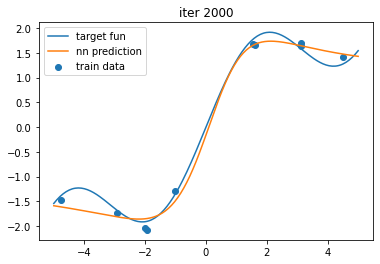

Iter 2100 | train: 0.0148310586810112 | test: 0.04286268353462219
Iter 2200 | train: 0.014408518560230732 | test: 0.041986238211393356
Iter 2300 | train: 0.01403424609452486 | test: 0.04121260717511177
Iter 2400 | train: 0.013696636073291302 | test: 0.040524739772081375
Iter 2500 | train: 0.013387098908424377 | test: 0.03990897908806801
Iter 2600 | train: 0.013099253177642822 | test: 0.03935433179140091
Iter 2700 | train: 0.012828457169234753 | test: 0.0388517901301384
Iter 2800 | train: 0.012571394443511963 | test: 0.038394201546907425
Iter 2900 | train: 0.012325617484748363 | test: 0.037975654006004333
Iter 3000 | train: 0.012089332565665245 | test: 0.037591300904750824


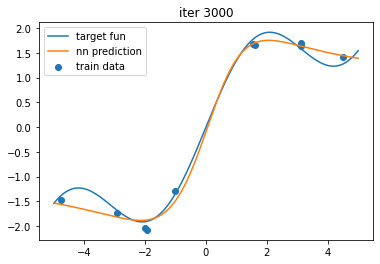

Iter 3100 | train: 0.011861277744174004 | test: 0.037237223237752914
Iter 3200 | train: 0.011640497483313084 | test: 0.036909978836774826
Iter 3300 | train: 0.011426357552409172 | test: 0.03660691902041435
Iter 3400 | train: 0.011218328028917313 | test: 0.03632573410868645
Iter 3500 | train: 0.01101600844413042 | test: 0.036064423620700836
Iter 3600 | train: 0.010819136165082455 | test: 0.03582129254937172
Iter 3700 | train: 0.010627481155097485 | test: 0.035594869405031204
Iter 3800 | train: 0.01044081524014473 | test: 0.035384003072977066
Iter 3900 | train: 0.010259028524160385 | test: 0.03518758714199066
Iter 4000 | train: 0.010081949643790722 | test: 0.03500468283891678


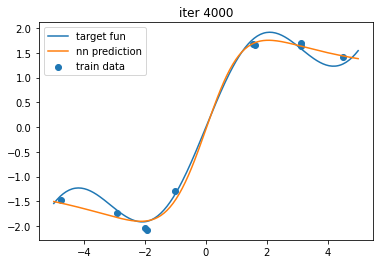

Iter 4100 | train: 0.009909461252391338 | test: 0.0348343700170517
Iter 4200 | train: 0.009741493500769138 | test: 0.03467602655291557
Iter 4300 | train: 0.009577909484505653 | test: 0.034528929740190506
Iter 4400 | train: 0.009418634697794914 | test: 0.03439253941178322
Iter 4500 | train: 0.009263549000024796 | test: 0.034266162663698196
Iter 4600 | train: 0.009112597443163395 | test: 0.034149471670389175
Iter 4700 | train: 0.00896566640585661 | test: 0.03404197841882706
Iter 4800 | train: 0.008822666481137276 | test: 0.03394317626953125
Iter 4900 | train: 0.008683517575263977 | test: 0.03385274484753609
Iter 5000 | train: 0.008548140525817871 | test: 0.03377043083310127


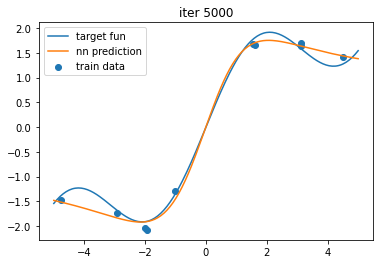

Iter 5100 | train: 0.0084164347499609 | test: 0.03369558975100517
Iter 5200 | train: 0.00828833319246769 | test: 0.033628229051828384
Iter 5300 | train: 0.008163752034306526 | test: 0.033567875623703
Iter 5400 | train: 0.008042586967349052 | test: 0.03351428359746933
Iter 5500 | train: 0.007924772799015045 | test: 0.033467259258031845
Iter 5600 | train: 0.007810249924659729 | test: 0.03342628851532936
Iter 5700 | train: 0.007698908448219299 | test: 0.033391352742910385
Iter 5800 | train: 0.0075906673446297646 | test: 0.033362142741680145
Iter 5900 | train: 0.007485467009246349 | test: 0.03333836421370506
Iter 6000 | train: 0.00738323712721467 | test: 0.03331993147730827


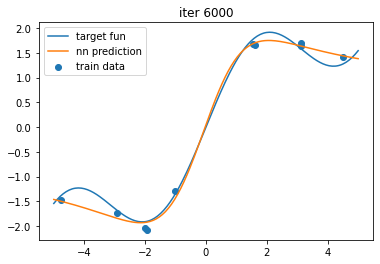

Iter 6100 | train: 0.007283887360244989 | test: 0.033306460827589035
Iter 6200 | train: 0.007187343202531338 | test: 0.033297814428806305
Iter 6300 | train: 0.0070935264229774475 | test: 0.03329378738999367
Iter 6400 | train: 0.007002366241067648 | test: 0.03329421207308769
Iter 6500 | train: 0.0069137997925281525 | test: 0.033298879861831665
Iter 6600 | train: 0.006827761884778738 | test: 0.03330758213996887
Iter 6700 | train: 0.006744160316884518 | test: 0.03332027420401573
Iter 6800 | train: 0.006662956438958645 | test: 0.03333663567900658
Iter 6900 | train: 0.006584043148905039 | test: 0.033356525003910065
Iter 7000 | train: 0.006507386919111013 | test: 0.03337984159588814


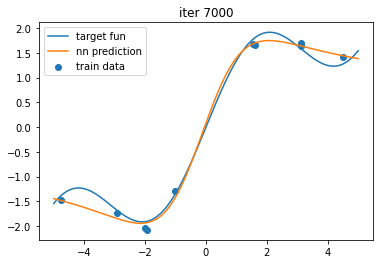

Iter 7100 | train: 0.006432902999222279 | test: 0.03340641409158707
Iter 7200 | train: 0.006360557861626148 | test: 0.03343605622649193
Iter 7300 | train: 0.0062902458012104034 | test: 0.033468738198280334
Iter 7400 | train: 0.006221957504749298 | test: 0.033504147082567215
Iter 7500 | train: 0.006155590061098337 | test: 0.03354225307703018
Iter 7600 | train: 0.006091098766773939 | test: 0.03358294814825058
Iter 7700 | train: 0.00602842727676034 | test: 0.033625975251197815
Iter 7800 | train: 0.005967534147202969 | test: 0.033671364188194275
Iter 7900 | train: 0.005908330902457237 | test: 0.03371898829936981
Iter 8000 | train: 0.005850782617926598 | test: 0.03376871719956398


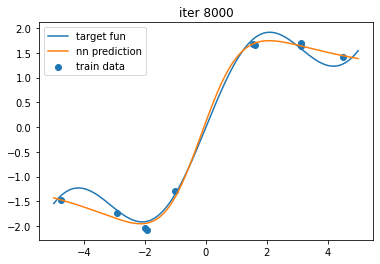

Iter 8100 | train: 0.005794851575046778 | test: 0.03382029011845589
Iter 8200 | train: 0.0057404604740440845 | test: 0.0338737815618515
Iter 8300 | train: 0.005687571130692959 | test: 0.0339290127158165
Iter 8400 | train: 0.005636138841509819 | test: 0.033985935151576996
Iter 8500 | train: 0.005586118903011084 | test: 0.03404444456100464
Iter 8600 | train: 0.0055374461226165295 | test: 0.034104421734809875
Iter 8700 | train: 0.005490097217261791 | test: 0.03416578844189644
Iter 8800 | train: 0.005444009322673082 | test: 0.03422847390174866
Iter 8900 | train: 0.005399164743721485 | test: 0.03429240360856056
Iter 9000 | train: 0.00535549083724618 | test: 0.034357503056526184


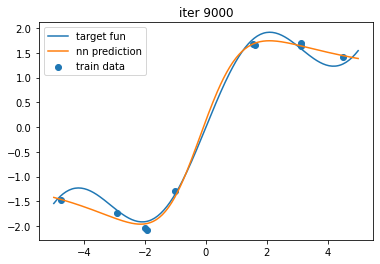

Iter 9100 | train: 0.005312968045473099 | test: 0.034423697739839554
Iter 9200 | train: 0.005271552596241236 | test: 0.034490909427404404
Iter 9300 | train: 0.0052312021143734455 | test: 0.034559063613414764
Iter 9400 | train: 0.005191888194531202 | test: 0.03462811931967735
Iter 9500 | train: 0.00515355821698904 | test: 0.034698016941547394
Iter 9600 | train: 0.005116195417940617 | test: 0.034768685698509216
Iter 9700 | train: 0.00507974810898304 | test: 0.03484011068940163
Iter 9800 | train: 0.005044213496148586 | test: 0.0349121056497097
Iter 9900 | train: 0.005009542219340801 | test: 0.03498469665646553
Iter 10000 | train: 0.004975683055818081 | test: 0.035057827830314636


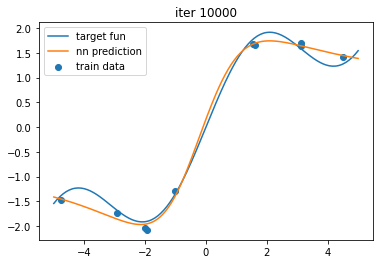

In [ ]:
for iter in range(10001):
  # Set gradients back to zero! Very important!
  # also remember that optim knows about all the tensors, so it will 
  # automatically set the gradients to zero for all of them. 
  optim.zero_grad()

  # Forward pass
  y_pred = model(x_train_t)

  # compute the loss
  train_loss = mse(y_pred, y_train_t)

  # Backward pass --> compute the partial derivatives automagically for us
  train_loss.backward()

  # Gradient update
  optim.step()

  # compute test loss (disable gradients for more efficiency)
  with torch.no_grad():
    test_loss = mse(model(x_test_t), y_test_t)

  # logging
  if iter % 100 == 0:
    print(f'Iter {iter} | train: {train_loss.item()} | test: {test_loss.item()}')
  if iter % 1000 == 0:
    plot_predictions(model, title=f'iter {iter}')